In [215]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [216]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black",
          "text.usetex" : True,
          "font.size" : 16,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"]}
plt.rcParams.update(params)

In [228]:
import requests
import io
def np_from_url(url):
    response = requests.get(url)
    response.raise_for_status()
    return np.load(io.BytesIO(response.content))

* Nonlinear optimization: Newton and trust-region methods. Introduction to JAX.
* Convex optimization
* Convex optimization (continued) 
* Applications $\longleftarrow$

# Lecture 9. Applications

Today, we discuss three problems wich you will have to solve in the Assignment 8 [Due 08/04/2023].

## Problem 1. Covariance estimation [70]

We consider (two) the multivariate ($n$ variables) timeseries (length $T$ steps) possibly with some of the observations missing (miss-rate $p$). These time series are sampled from multivariate normal distributions:

$$
P(\mathbf {x})=(2\pi )^{-k/2}\det({\boldsymbol {\Sigma }})^{-1/2}\,\exp \left(-{\frac {1}{2}}\mathbf {x}^{\!{\mathsf {T}}}{\boldsymbol {\Sigma }}^{-1}\mathbf {x}\right).
$$

For each time series, the covariance matrix $\boldsymbol {\Sigma }$ is positive definite of a specific form:

$$
\boldsymbol {\Sigma } = \boldsymbol {C}\boldsymbol {C}^T+\alpha\boldsymbol {1}
$$

where $\boldsymbol {C}$ is a tall $n\times k$ matrix and $\alpha>0$. You are given the timeseries, and your task is to estimate the matrix $\boldsymbol {\Sigma}$ as accurately as possible. In both cases, $k=2$.

Lets inspect the timeseries.

In [283]:
X1 = np_from_url("https://s193vla.storage.yandex.net/rdisk/45c153baa874274c383aab7ebccfb13c2e6b21d60dcf8f4a8282100d6cf6c587/6415baa5/XChvIsLTjCprW4zYIFRb_XCEnUSUfDD6gVgnC6OFR2Ajrn9T8-dogoCLIqZT7Nmy11B_g9juoLIEDTSTm1Fwtw==?uid=0&filename=X1.npy&disposition=attachment&hash=605SMNnbdg2/BmIY1IUTW1RGAPzQ3stA3I%2BCtyghdMqBNVapuEST0doFaQw2Fc%2BYq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=2528&hid=a4d19b4de254c67623996623c1d25c5e&media_type=data&tknv=v2&rtoken=XnVjMZ9nibl1&force_default=no&ycrid=na-46437700702bb6d2f85b7027370ca18f-downloader9h&ts=5f72c8f383340&s=ae74c6a65c352f5a6eba166d92cedf4bf604e691357e58e8491a245a64a43450&pb=U2FsdGVkX1-gyOZXdC6ZP0d8lojjWfAQraFVqrtDfDyhGek7TtWw10TPOpXM3e7swfy-GKk-YuLOovZfaEdVpwbtZDRV0SAoe7NewzHndmg")
X2 = np_from_url("https://s19vlx.storage.yandex.net/rdisk/44afb82fd64cdce114669a93f279762ee6af0db0a490ee4315f8c5ea6da93031/6415bae1/XChvIsLTjCprW4zYIFRb_RqluC0-7FmgH1QALIgzyCHI7ZD1pmmMwXAGfKPouqIaUIY2Gelf2mdVGupngMyEDw==?uid=0&filename=X2.npy&disposition=attachment&hash=fT8nvQByQK5OGflBX9N1wQl0YWhPK3wmjZPOh6gzoeWQFmsuYYFeKJccXSODx5sdq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=2528&hid=03c7ec08f14d99756d784145efaa973d&media_type=data&tknv=v2&rtoken=aHWCAk5uylA1&force_default=no&ycrid=na-4c5f358af9f93387832d24b889868591-downloader9h&ts=5f72c92cbba40&s=67ce027fb04952a759874b0b7a0ac880adb8978c51192ed8a0d586c3124bdcbb&pb=U2FsdGVkX1_4As8tDpQfYVqQGC23k9XDluPW2qyTY5yayFLnamV2PV18yBNjseuK_JW8qABoPFGnAXqXrWZQCFWu3CbyqGrzisiCAvLgTzQ")

In [284]:
# all data available
print(X1.shape)
print(np.isnan(X1).mean())

(20, 15)
0.0


In [285]:
# ~20% of missing data
print(X2.shape)
print(np.isnan(X2).mean())

(20, 15)
0.18



In both cases, we have $n=15$ and $T=20$. In the second time series, roughly 20\% of observations are missing. How do we estimate the covariance matrices $\boldsymbol {\Sigma }_1$ and $\boldsymbol {\Sigma }_2$ given the observations and additional information above? Before we switch to that, lets set up the scoring rule: how do we evaluate the accuracy of such estimation? From the probabilistic point of view, it makes sence to rely on the [Kullback–Leibler_divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the true covariance matrix and estimated one. A simple interpretation of the KL divergence of P from Q is the expected excess surprise from using Q as a model when the actual distribution is P. Formally, for distributions $P$ and $Q$ of a continuous random variable, it is defined to be the integral:

$$
\displaystyle D_{\text{KL}}(P\parallel Q)=\int _{-\infty }^{\infty }p(x)\log \left({\frac {p(x)}{q(x)}}\right)\,dx.
$$


In the case of multivariate normal distributions with zero mean it becomes:

$$
{\displaystyle DD_{\text{KL}}(\Sigma _{0}\parallel \Sigma _{1})={\frac {1}{2}}\left(\operatorname {tr} \left(\Sigma _{1}^{-1}\Sigma _{0}\right)-n+\ln \left({\frac {\det \Sigma _{1}}{\det \Sigma _{0}}}\right)\right).}
$$

We will use this formula, having in mind that $\Sigma_{0}$ is the true covariance matrix and $\Sigma_{1}$ is the proposed estimation. Note that the smaller $D$ the better the estimation is and $D\ge0$.

In this exercise, your are given the timeseries and do not have access to the true covariance matrices, which were used to generate them. So, optimizing $D$ is not an option. How do we estimate $\Sigma$ then?

### Time series X1 [30]

 Lets consider the first time series where $p=0$ (no missing data) first. 

In [286]:
T = X1.shape[0]
cov_emp = (X1.T @ X1) / T

In [287]:
cov_emp.shape

(15, 15)

Empirical covariance matrix is not necessary the best estimate for $\Sigma$, since we know that true $\Sigma$ does have some structure. Does the empirical matrix satisfy it?

Your goal is thus to find the most suitable matrix of the given form

$$
\boldsymbol {\Sigma } = \boldsymbol {C}\boldsymbol {C}^T+\alpha\boldsymbol {1}.
$$

The most suitable matrix is the one which maximizes the likelihood of the observed data:

$$
L(\Sigma) = \Pi_{t=1}^{t=T} P(\mathbf {x}_t)
$$

In practice, its more convenient to maximize the mean log-likelihood which in this case reads:

$$
LL(\Sigma) = \frac{1}{T}\ln L = \frac{1}{T}\sum_{t=1}^T \ln P(\mathbf {x}_t).
$$

One can show that LL is in fact a function of empirical covariance matrix and of $\Sigma$. If tou have trouble with that, check
You thus will have to maximize

$$
LL(\boldsymbol {C}\boldsymbol {C}^T+\alpha\boldsymbol {1}, \Sigma_{emp})
$$

over $\boldsymbol {C}$ and $\alpha>0$. You have to set up the cost function in JAX and use some 2nd-order optimization algorithm. Dont forget to compile your cost function as well as its gradients for speed-up. What should we try using as a staring point of optimization algorithm?

In [288]:
u, v = np.linalg.eigh(cov_emp)
vb = v * u[None, :]**0.5
np.testing.assert_array_almost_equal(cov_emp, vb @ vb.T)

In [289]:
C = vb[:, -2:]
alpha = -np.mean(np.diag(C @ C.T - cov_emp))

In [290]:
cov_emp[:4,:4]

array([[ 1.68864896, -0.3714489 ,  0.22169503,  0.25602984],
       [-0.3714489 ,  1.88797191,  0.30403957,  0.57257598],
       [ 0.22169503,  0.30403957,  1.88338779,  1.00489232],
       [ 0.25602984,  0.57257598,  1.00489232,  4.57206023]])

In [291]:
(C @ C.T + np.eye(np.shape(cov_emp)[0])*alpha)[:4,:4]

array([[1.64180981, 0.09234269, 0.21066344, 0.75344405],
       [0.09234269, 1.78079722, 0.26749554, 0.71659767],
       [0.21066344, 0.26749554, 1.75562083, 0.99576349],
       [0.75344405, 0.71659767, 0.99576349, 4.70091832]])

In [292]:
# could do better, but its just a starting point of the iterative optimization algorithm

 ### Time series X2 [40]

In [293]:
X2[0,:]

array([-1.36648578,         nan, -1.98888942,  3.77641346, -1.42057588,
               nan, -0.24258252, -0.34031763, -0.42603018,         nan,
               nan, -1.61419952,         nan, -0.22179938,  1.67828446])

Clearly, the missing data make things a bit more complicated. How do we write the cost function to optimize? The main problem with this function is that

$$
L(\Sigma) = \Pi_{t=1}^T P(\mathbf {x}_t)
$$

can not be computed in full glory due to missing observations $x_{ti}$ for some $t$ and $i$ (in our case, at $t=1,\;i\in[1, 5, 9, 10, 12]$ are missing). In such a situation, the most systematic way would be to integrate the unobserved values out. For example, $t=1$ factor in the log-likelihood will look like:

$$
\int P(x_{1,0}; x_{1,1}; x_{1,14}) dx_{1,1}dx_{1,5}dx_{1,9}dx_{1,10}dx_{1,12}
$$

and will depend only the observed variables. The integrals can be conveniently expressed in terms of inverse of submatrices of $\Sigma$. Set up the corresponding cost function and optimize it over $\Sigma$, similarly to the first case. To better understand whats going on, consider on the piece of paper the case of $t=n=2$ and some missing observations.

## Problem 2. Source localization [40]

A signal emitted by a source at an unknown position $r \in R^2$ is received by m sensors at known positions $r_1, . . . , r_m \in R^2$.
From the strength of the received signals, we can obtain noisy estimates $d_k$ of the distances $\Vert r−r_k \Vert_2$. We are interested in estimating the source position $r$ based on the measured distances $d_k$. Formally, we have to minimize:

$$
L(r) = \sum_k \left(\Vert r - r_k\Vert_2^2 - d_k^2\right)^2
$$

over $r$ at given $r_k$ and $d_k$. Is this problem convex?

Lets take a look at an example.

In [266]:
P = np_from_url("https://s418vla.storage.yandex.net/rdisk/a77f1aa73b4c09fb6af2cb34539463e3508cedc205b95609dec4bda9e6a99e2d/6415bc38/XChvIsLTjCprW4zYIFRb_f2GTALtIi6mhY5VOXSeHh-nAZfxjozgypZTMKP0j1atKzyMpdRLEouf280GdAMClA==?uid=0&filename=P.npy&disposition=attachment&hash=AOorn7n%2BSDtEKF7uXnNNNSY/Bzi8Pq/h9CkNJWnQdXvKh8Hv3%2BDDZ46wkSs3PZQSq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=208&hid=67b52c027e0785f5a044a265afdfbecd&media_type=data&tknv=v2&rtoken=HTnbsKxz8jgO&force_default=no&ycrid=na-e9c82d01ae3665ed01e6e65ba398337d-downloader9h&ts=5f72ca73d7e00&s=d0ae5c33d68788a362166126af3ecf82288733b7e167657d57e702c38b70d89f&pb=U2FsdGVkX18Fu9BeuS49i5OtThCath1YJQzUgI4cZWjRyd38k0QG6vcWsKp_p-PpezxjJ_xs_45KeIyaUN0Fvgx9Psd1qJDGffdL693HfS4")
d = np_from_url("https://s234vla.storage.yandex.net/rdisk/3940e308cefbb1ec93c5caf41868a421f84324dfe735872278a39643454578db/6415bc5d/XChvIsLTjCprW4zYIFRb_cW_kEozr-_WufxZL_52_qIWmqfFJnUNLt7TBgK0tZX2rkiQ_Qka8H_iyp4NfhrXdQ==?uid=0&filename=d.npy&disposition=attachment&hash=/OeZNS/ZTwN8KxI0fZDEkGLpHk4pJoG2Bg8Wdi/YYlkgIJEgX7rlwK60ph5vzvLwq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=168&hid=78ddcea47f130cf5780d5f10c38a7c0e&media_type=data&tknv=v2&rtoken=1V25z9ZSC5It&force_default=no&ycrid=na-a94e0b74a2a6fe21482fd53e15d14806-downloader9h&ts=5f72ca9721140&s=4c0b8666a3455782f23cc1be5ad213f2e628dc40a694a496e9a9e8ad45e6dead&pb=U2FsdGVkX1-zSBmG3JVzhidsNRsARoLhgbbXHXHFuYsf0pL5oEIE8xQbqBk1Vspq4AmKW3_W2Yu_7F3A58TiaP6Hi02MWM_GOisUyIEjANI")

In [269]:
# positions of sensors
P

array([[-1.84625944, -8.8926792 ],
       [ 5.77069755, -4.2538963 ],
       [-0.99298826, -3.92175389],
       [ 0.52799049,  2.47624426],
       [ 5.53550915,  3.72483291]])

In [270]:
# estimated distances
d

array([15.83664881,  7.40992648, 12.20264784,  9.10339534,  4.44793155])

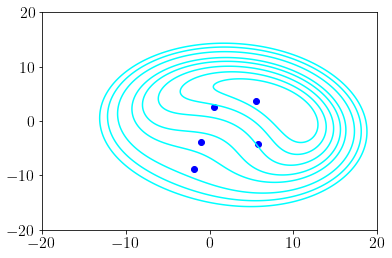

In [272]:
# visualization of the problem

L = 10
def fun(y):
    return np.sum((np.sum((y - P)**2, 1) - d**2)**2)
delta = L/100
hi = 2*L
x = np.arange(-hi, hi, delta)
y = np.arange(-hi, hi, delta)
X, Y = np.meshgrid(x, y)
R = np.dstack([X, Y])
F = np.array([[fun(R[j, i, :]) for i in range(R.shape[1])] for j in range(R.shape[0])])

plt.scatter(P[:, 0], P[:, 1], color='blue')
plt.xlim(-hi, hi)
plt.ylim(-hi, hi)
plt.contour(X, Y, F, np.mean(F)*np.array([0.03, 0.06, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]), colors = ['cyan'])

The blue dots show the positions of the detectors and cyan lines show the countour lines of the cost function $L(r=(x, y))$. Your goal in this task is to find the position fo the minimum using the method of Lagrange multipliers. In order to see how it may work, consider rewriting the optimization problem identically, from

$$
\min_r \sum_k \left(\Vert r - r_k\Vert_2^2 - d_k^2\right)^2 = \min_r \sum_k \left(\Vert r \Vert_2^2 +\Vert r_k \Vert_2^2 - 2 r\cdot r_k- d_k^2\right)^2
$$

to 

$$
\min_{r, t} \sum_k \left(t +\Vert r_k \Vert_2^2 - 2 r\cdot r_k- d_k^2\right)^2\quad\textrm{s.t.}\quad\Vert r\Vert_2^2=t
$$


The latter minimization under constraint is reduced to finding stationary points in $r=(x, y)$ and $t$ of the following Lagrangian

$$
\bar L(x, y, t) =  \sum_k \left(t +\Vert r_k \Vert_2^2 - 2 r\cdot r_k- d_k^2\right)^2+\lambda\left(\Vert r\Vert_2^2-t\right).
$$

Since this is just a quadratic form over $x, y, t$, the stationary point can be found explicitely as $x(\lambda), y(\lambda), t(\lambda)$ can be found explicitely (express the in terms of $r_k$ and $d_k$).

Finally, solve numerically the polynomial equation $x(\lambda)^2+y(\lambda)^2-t(\lambda)=0$ over $\lambda$ to find the point, which delivers the optimimum for the given data. Plot all extremal points on the graph above and characterize them (local/global maximum/minimum).

## Problem 3 Trading with costs  [25]

Consider a universe of $n$ stocks over $T$ days, with noisy predictions for the stock returns $p_{ti}$ available in the file below.

In [294]:
p = np_from_url("https://s354sas.storage.yandex.net/rdisk/837d8b9dea0ab222b0829636b2e85ec4e2fd6aaf216ad362727637ff01614975/6415bda9/XChvIsLTjCprW4zYIFRb_f7hEwuujyL3TeUaz-40k0WWNpU_s9K_dzifyBfl-4Z_L3lLs_x4vN9GtZ-BVmo59Q==?uid=0&filename=pred.npy&disposition=attachment&hash=QaJlPGU7QDY6fs2RZ0jonZrdxOFHMakzMajzg4VKaYb0VTbZ%2BmqT414LaAonFdcUq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=158688&hid=c9abfd480b61e479eec854ec7a2966fb&media_type=data&tknv=v2&rtoken=YxgJMcA30b4b&force_default=no&ycrid=na-875a8a73cad54f1449b48010eb1f720c-downloader6h&ts=5f72cbd3bfc40&s=9237023b8acd5f4e6d01e0934976609178c2672fce0dc11970fa22b0e4f93542&pb=U2FsdGVkX18TolMUXWQb3dGT05XE-oSZh9SAi6XkeO7LJuWV3rbbZwUyvo6wZPofAL47v45LEmdWY9yVI7oazaNmiqjCbxl0nH-QDzHzxJU")

Another information is stationary estimation of the covariance matrix $\Omega$ of the stock returns,

In [295]:
cov = np_from_url("https://s147vla.storage.yandex.net/rdisk/cbd46204f80e60ddd8d5fcad782115d3eef9a20987297bd9889c57b599518b25/6415bf25/XChvIsLTjCprW4zYIFRb_Tj9bErrtidk06uMt33IYsXWXGerxDDL99GB9LXyIwXNsMPu6GFsgQ9oAgX5am1gOA==?uid=0&filename=cov.npy&disposition=attachment&hash=FMfnuxzpoRW8IxdHqedZo3dxzpLyojUDepYQ%2B%2B1TxX/9y3lYrNesW4OnsDX4bDfzq/J6bpmRyOJonT3VoXnDag%3D%3D&limit=0&content_type=application%2Foctet-stream&owner_uid=225322961&fsize=3328&hid=dd5d95b674b50ef82fd86a84995d68d3&media_type=data&tknv=v2&rtoken=dtug7DYpZLp0&force_default=no&ycrid=na-8cdc143be98b25c67b6ba7def4f072d2-downloader24h&ts=5f72cd3e25340&s=4dedcacbeb3c5cdfafb21b85f15a9e1446693d84f8c730ea1ce42430e8af75a1&pb=U2FsdGVkX19biUrcAobRqRGtWKfyou_GB2rLj4x4zULx9u8KJcf2NVQAdusIB62jpoXXVRNfq9D1QryuWi1WLZ68y-4Z8cboYpMr43JECtw")

Assuming that we have the position evolving as $\pi_t$ ($\pi_t$ at each $t$ is a vector of $n$ components), expected risk-adjusted gain $G$ reads
$$
G = \sum_{t} \left[p_{t} \cdot\pi_{t} - \pi_{t}\cdot \Omega \cdot \pi_{t} - \gamma\sum_i |\pi_{t,i} - \pi_{t-1,i}|\right]
$$
and has to be maximized over $\pi_t$ (pick $\gamma=0.01$)

To make it more clear, you start with $t=0$ when $\pi_0=0$ by definition. At this moment, you have access to $p_1$ (expected return at the next day) and have to maximize:

$$
p_1\pi_1 - \pi_1\Omega\pi_1 - \gamma \sum_i |\pi_{1, i} - 0|\longrightarrow \max
$$
over $\pi_1$. Show that this is a concave function of $\pi_1$ and maximize it using $\texttt{cvxpy}$.

At $t=1$ you have already found $\pi_1$. At this moment, you have access to $p_2$ and have to maximize:

$$
p_2\pi_2 - \pi_2\Omega\pi_2 - \gamma \sum_i |\pi_{2, i} - \pi_{1, i}|\longrightarrow \max
$$

Repeat the process until you reach the end of the time series. The corresponding $\pi_{ti}$ should be stored as a file: this will be you 1st result in this problem. 

Check yourself considering the case of $\gamma=0$: in this case, optimization of $G$ can be done directly. Make sure the result of such direct computation coinsides with $\texttt{cvxpy}$ result. The corresponding $\pi_{ti}$ should be stored as a file: this will be your 2nd result in this problem.

Compute expected gain/costs (the first and the third terms in 3) over the full period for two trading strategies computed above (note that the trading costs are present even if you decided to optimize at $\gamma=0$).

### Interpretation

In this problem, you are given the noisy estimates of the stock returns, $p_{it}$ and the true returns $r_{it}$ are known only to the problem author. If the true returns are known, the trading strategy ($\pi_t$) can be evaluated by computing the PnL:

$$
PnL_t = r_{t} \cdot\pi_{t} - \gamma\sum_i |\pi_{t,i} - \pi_{t-1,i}|
$$

After the problem is solved, we will compute $PnL_t$ discuss the results.